In [1]:
import time
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import colormaps as cm
from pathlib import Path
import csv
import glob
import os

In [2]:
gs = {'torino': -196, 'fez': -246, 'kyiv': -194}

In [3]:
res = {}
for which in ['fez', 'kyiv', 'torino']:
    for ang in [16, 27, 'lin']:
        for les in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'neg.', 'pos.']:
            for p in range(50):
                fname = Path(f"./results/Hamiltonian_ibm_{which}_0/{ang}_{les}/{p=}/results.csv")
                try:
                    with open(fname, 'r') as f:
                        rd = csv.DictReader(f, delimiter=';', quotechar="'")
                        ind = (which, ang, les, p)
                        res[ind] = list(rd)                
                except FileNotFoundError:
                    pass

for k, v in res.items():
    for x in v:
        for kk in ["eng", "Delta", "chi", "D"]:
            x[kk] = float(x[kk])


In [4]:
def plot_energy_lin(ind):

    clrs = {"BP": 'blue', "CTM": 'red', 'MPS': 'green'}
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(5, 3)
    miny = 0
    maxy = -1000
    if ind in res:
        for pt in res[ind]:
            mrk = 'x' if pt["chi"] == 1 else '+'
            clr = clrs[pt["env"]]
            ax.scatter([1 / float(pt["D"])], float(pt["eng"]),
                        marker=mrk, color=clr, s=50)
            miny = min(miny, float(pt["eng"]))
            maxy = max(maxy, float(pt["eng"]))

        #ax.set_xscale('log')
        ax.set_xlabel('1 / D')
        ax.set_ylabel(f'eng')
        ax.set_ylim(miny-1, maxy+1)
        ax.set_xlim(0, 1)

        ax.grid(which='major')
        ax.grid(which='minor')
        ax.set_title(f'{ind}')

        ax.scatter([1.2], [1e-2], marker='+', color='black', s=50, label='chi>1')
        ax.scatter([1.2], [1e-2], marker='x', color='black', s=50, label='BP (chi=1)')
        for k, v in clrs.items():
            ax.scatter([1.2], [1e-2], marker='o', color=v, s=50, label=k)

        ax.legend()
    # plt.legend()
# plt.show()

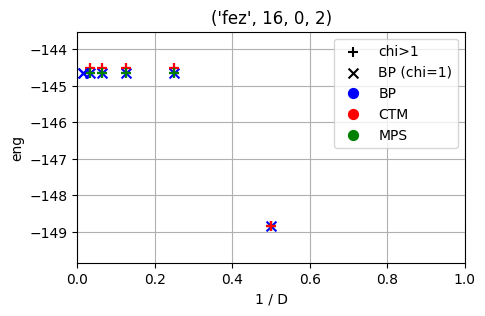

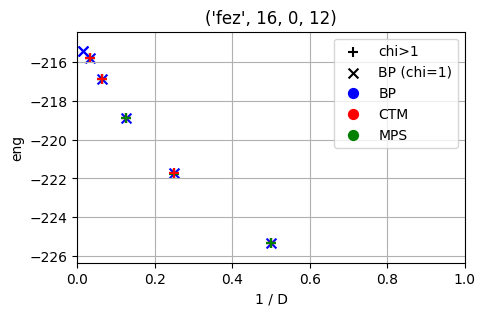

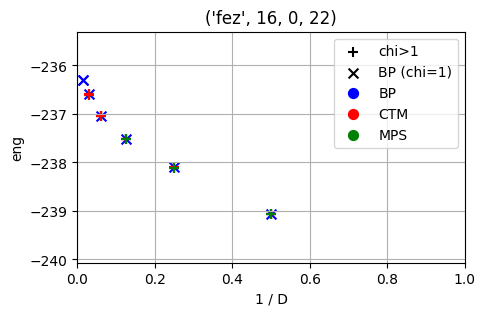

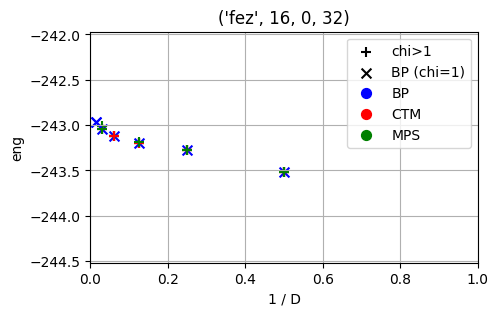

In [5]:
for p in range(2, 37, 10):
    plot_energy_lin(('fez', 16, 0, p))


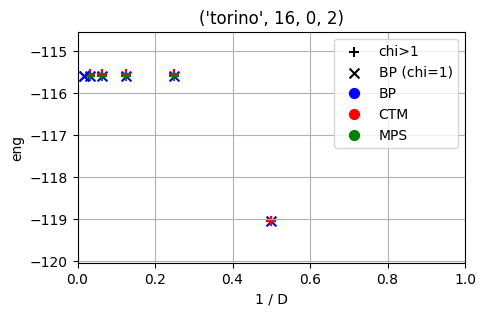

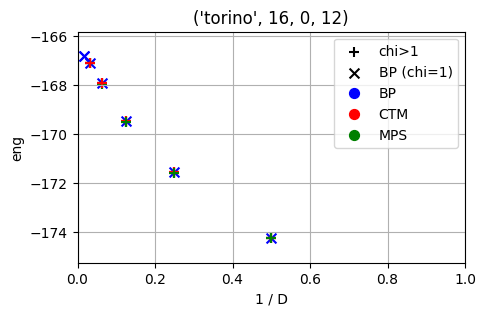

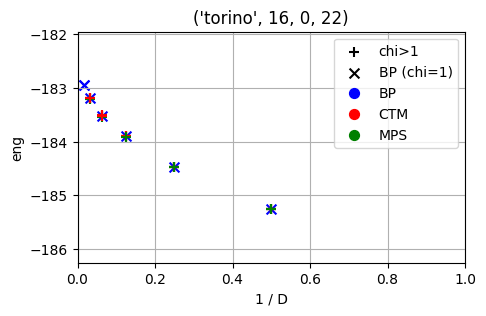

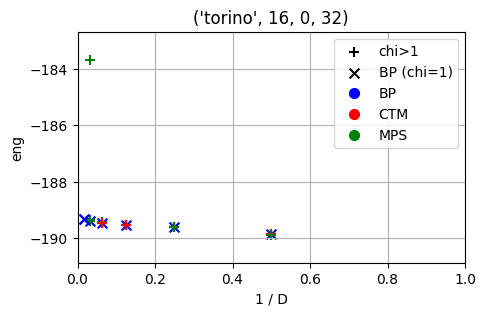

In [6]:
for p in range(2, 37, 10):
    plot_energy_lin(('torino', 16, 0, p))

In [7]:
def plot_energy_diff(which, ang, les):

    ps = list(range(4, 37))
    evs6432, evs3216= [], []
    for p in ps:
        ind = (which, ang, les, p)
        ev32, ev16, ev64 = 0, 0, 0
        
        for x in res[ind]:
            if x['D'] == 32 and x['env'] == 'BP':
                ev32 = float(x['eng'])
        
        for x in res[ind]:
            if x['D'] == 16 and x['env'] == 'BP':
                ev16 = float(x['eng'])

        for x in res[ind]:
            if x['D'] == 64 and x['env'] == 'BP':
                ev64 = float(x['eng'])
        
        
        evs6432.append((ev64-ev32) if ev64 < -10 else 0)    
        evs3216.append((ev64-ev16))    
    
    clrs = {'fez':'green', 'kyiv':'blue', 'torino':'red'}
    plt.plot(ps, evs6432, '-+', label=f"{which}, E(D=64) - E(D=32)", color=clrs[which])
    plt.plot(ps, evs3216, '-o', label=f"{which}, E(D=64) - E(D=16)", color=clrs[which])

    plt.xlabel('p')
    plt.ylabel(f'energy convergence')


    plt.legend()
    plt.show()

Compare energy (in BP) for D64, D32, D16;  [convergence with D]

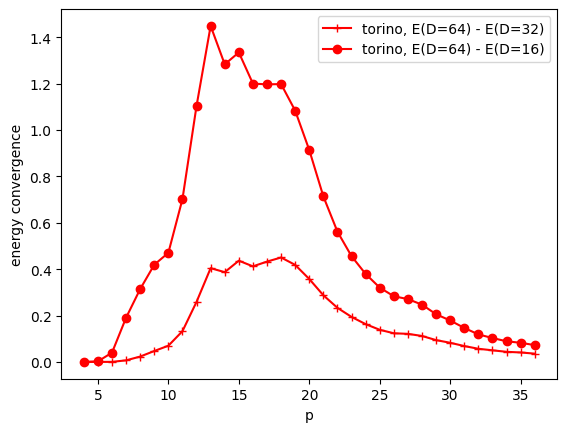

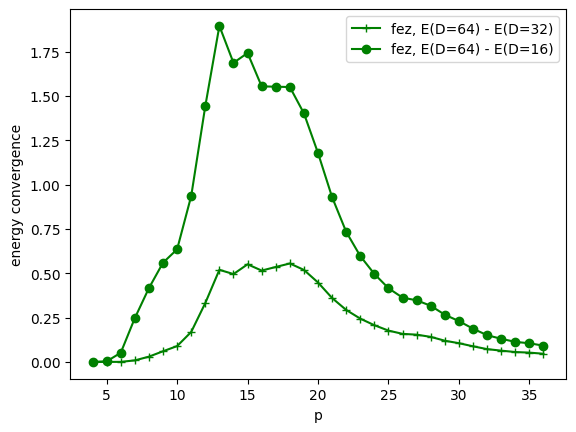

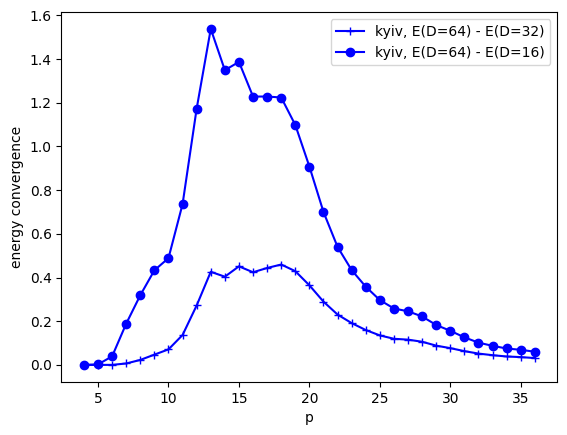

In [8]:
for which in gs:
    plot_energy_diff(which, 16, 0)


In [9]:
def plot_energy(which, ang, les, color='b', Dref=32):

    ps = []
    evs = []
    try:
        for p in range(4, 100):
            ind = (which, ang, les, p)
            ev1 = 0
            for x in res[ind]:
                if x['D'] == Dref and x['env'] == 'BP':
                    ev1 = float(x['eng'])
            evs.append(ev1)    
            ps.append(p)
    except:
        pass

    evs = np.array(evs) - gs[which]
    plt.set_cmap("Greens") 
    plt.semilogy(ps, evs, '-+', label=f"{ang}_{les}", color=color)
    plt.grid(visible=True, which='major', linestyle='-', axis='y')
    plt.grid(visible=True, which='minor', linestyle='--', axis='y')

    plt.xlabel('p')
    plt.ylabel(f'E_16 - E_GS')
    plt.title(f"{which}")
    plt.ylim([1, 100])
    plt.legend(ncol=4)

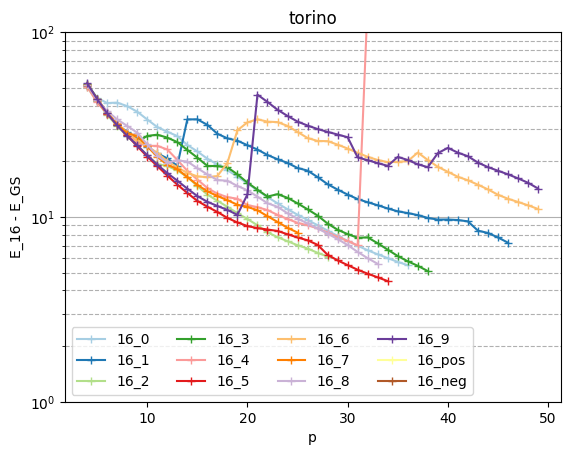

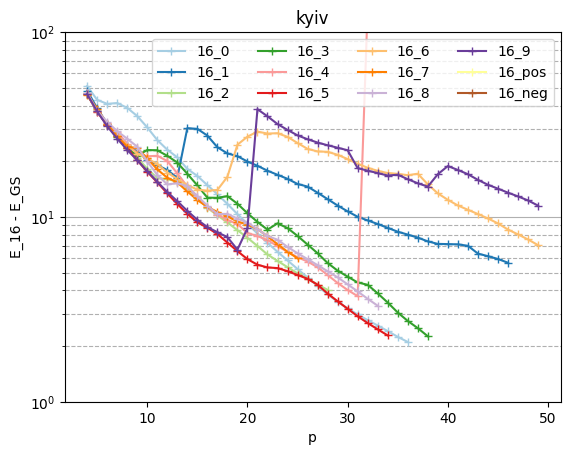

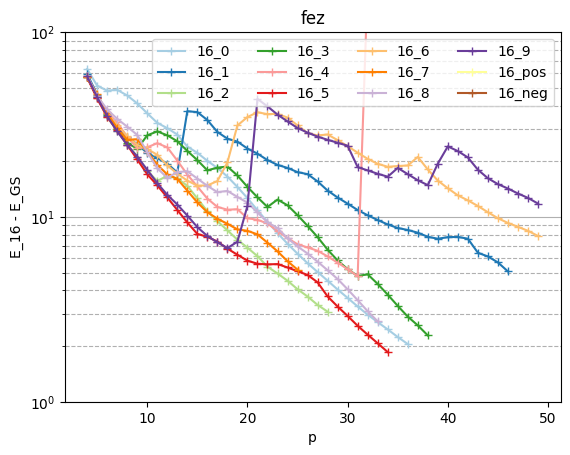

In [10]:
colors = [cm["Paired"](ii) for ii in range(12)]
for which in ['torino', 'kyiv', 'fez']:
    for p, c in zip([0,1,2,3,4,5,6,7,8,9,'pos', 'neg'], colors):
        plot_energy(which, 16, p, c)
    plt.show()

In [11]:
def plot_contraction_comparison(ind):

    clrs = {"BP": 'blue', "CTM": 'red', 'MPS': 'green'}
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(5, 3)

    if ind in res:
        tmp = {(x['D'], x['env'], x['chi']): float(x['eng'])  for x in res[ind]}
        try:
            for D in [4, 8, 16, 32]:
                dE = tmp[(D, 'BP', 1)] - tmp[(D, 'MPS', 8)] 
                ax.scatter([1 / float(D)], abs(dE),
                            marker='+', color='b', s=100)
                
                dE = tmp[(D, 'BP', 1)] - tmp[(D, 'CTM', 8)] 
                ax.scatter([1 / float(D)], abs(dE),
                            marker='x', color='r', s=100)
        except KeyError:
            pass

    ax.set_yscale('log')
    ax.set_xlabel('1 / D')
    ax.set_ylabel(f'|E(MPS chi=8) - E(BP chi=1)|')
    ax.set_ylim(1e-6, 1e-0)
    ax.set_xlim(0, 0.26)

    ax.grid(which='major')
    ax.grid(which='minor')
    ax.set_title(f"{ind}")
    plt.show()

Here show convergence of energy (energy difference) between BP and MPS/CTM with chi=8

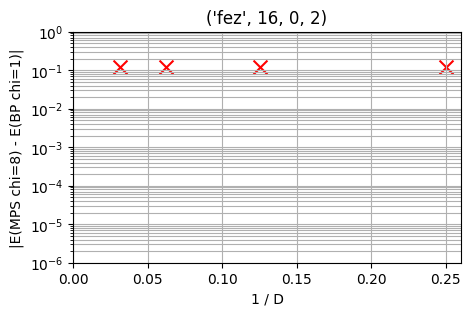

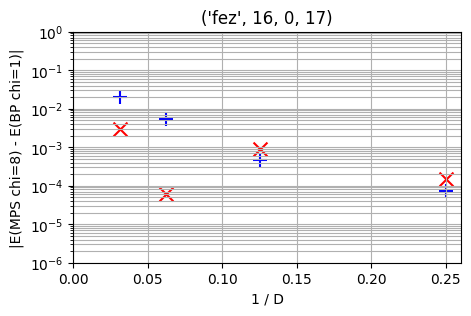

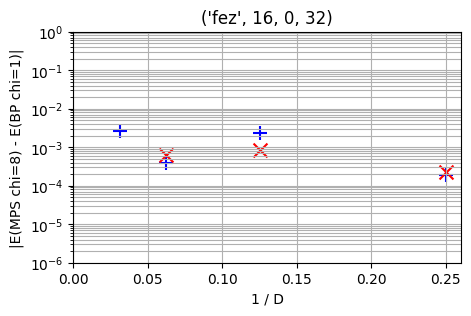

In [12]:
for p in range(2, 37, 15):
    plot_contraction_comparison(('fez', 16, 0, p))


In [13]:
smpls = {}
tt = 'BP_chi=1'
for which in ['fez', 'kyiv', 'torino']:
    for ang in [16]:
        for les in [0,1,2,3,4,5,6,7,8,9,'pos', 'neg']:
            for p in range(60):
                for D in [8, 32, 64]:
                    fname = Path(f"./results/Hamiltonian_ibm_{which}_0/{ang}_{les}/{p=}/samples_D={D}_{tt}.npy")
                    try:
                        ind = (which, ang, les, p, D)
                        smpls[ind] = np.load(fname, allow_pickle=True).item()
                    except FileNotFoundError:
                        pass

-196


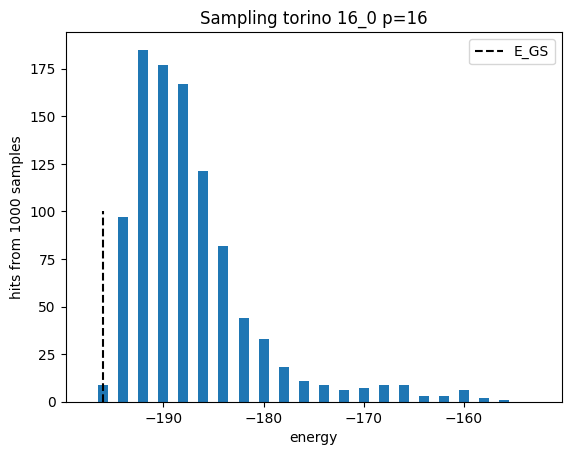

In [14]:
which = 'torino'
ee = smpls[(which, 16, 2, 25, 32)]['energies'].astype(np.int64)
bins=np.array(list(range(min(ee)-1, max(ee)+1) )) - 0.5
plt.hist(ee, bins=bins);
plt.plot([gs[which], gs[which]], [0, 100], '--k', label='E_GS')
plt.legend()
plt.title(f"Sampling {which} 16_0 p=16")
plt.xlabel("energy")
plt.ylabel("hits from 1000 samples")
print(np.min(ee))

In [15]:
def plot_probability_ax(ax, which, ang, les, color='b', dE = 0, deg={}, D = 64):
    ps = []
    pp = []
    try:
        for p in range(4, 100):
            ind = (which, ang, les, p, D)
            ss = smpls[ind]['energies'].astype(np.int64)
            iii = (ss <= gs[which] + dE)
            prob = sum(iii) / len(ss)
            #pfound = sum(np.array(smpls[ind]['probabilities'])[iii]) / sum(iii)
            pp.append(prob)
            ps.append(p)
            # if prob > 0:
            #     deg[which].append(prob / pfound)
    except:
        pass

    ax.semilogy(ps, pp, '-+', label=f"{ang}_{les}", color=color)
    ax.grid(visible=True, which='major', linestyle='-', axis='y')
    ax.grid(visible=True, which='minor', linestyle='--', axis='y')

    ax.set_xlabel('p')
    ax.set_ylabel(f'Probability( E <= E_gs + {dE})')
    ax.set_title(f"{which}")
    ax.set_ylim([1e-3, 1])
    
    

In [16]:
def plot_energy_ax(ax, which, ang, les, color='b', Dref=64):

    ps = []
    evs = []
    try:
        for p in range(4, 100):
            ind = (which, ang, les, p)
            ev1 = 0
            for x in res[ind]:
                if x['D'] == Dref and x['env'] == 'BP':
                    ev1 = float(x['eng'])
            evs.append(ev1)    
            ps.append(p)
    except:
        pass

    evs = np.array(evs) - gs[which]
    ax.semilogy(ps, evs, '-+', label=f"{ang}_{les}", color=color)
    ax.grid(visible=True, which='major', linestyle='-', axis='y')
    ax.grid(visible=True, which='minor', linestyle='--', axis='y')

    ax.set_xlabel('p')
    ax.set_ylabel(f'E - E_GS')
    ax.set_title(f"{which}")
    ax.set_ylim([1, 100])
    # ax.legend(ncol=2)

/tmp/ipykernel_64362/3784016678.py:25: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_ylim([1e-3, 1])


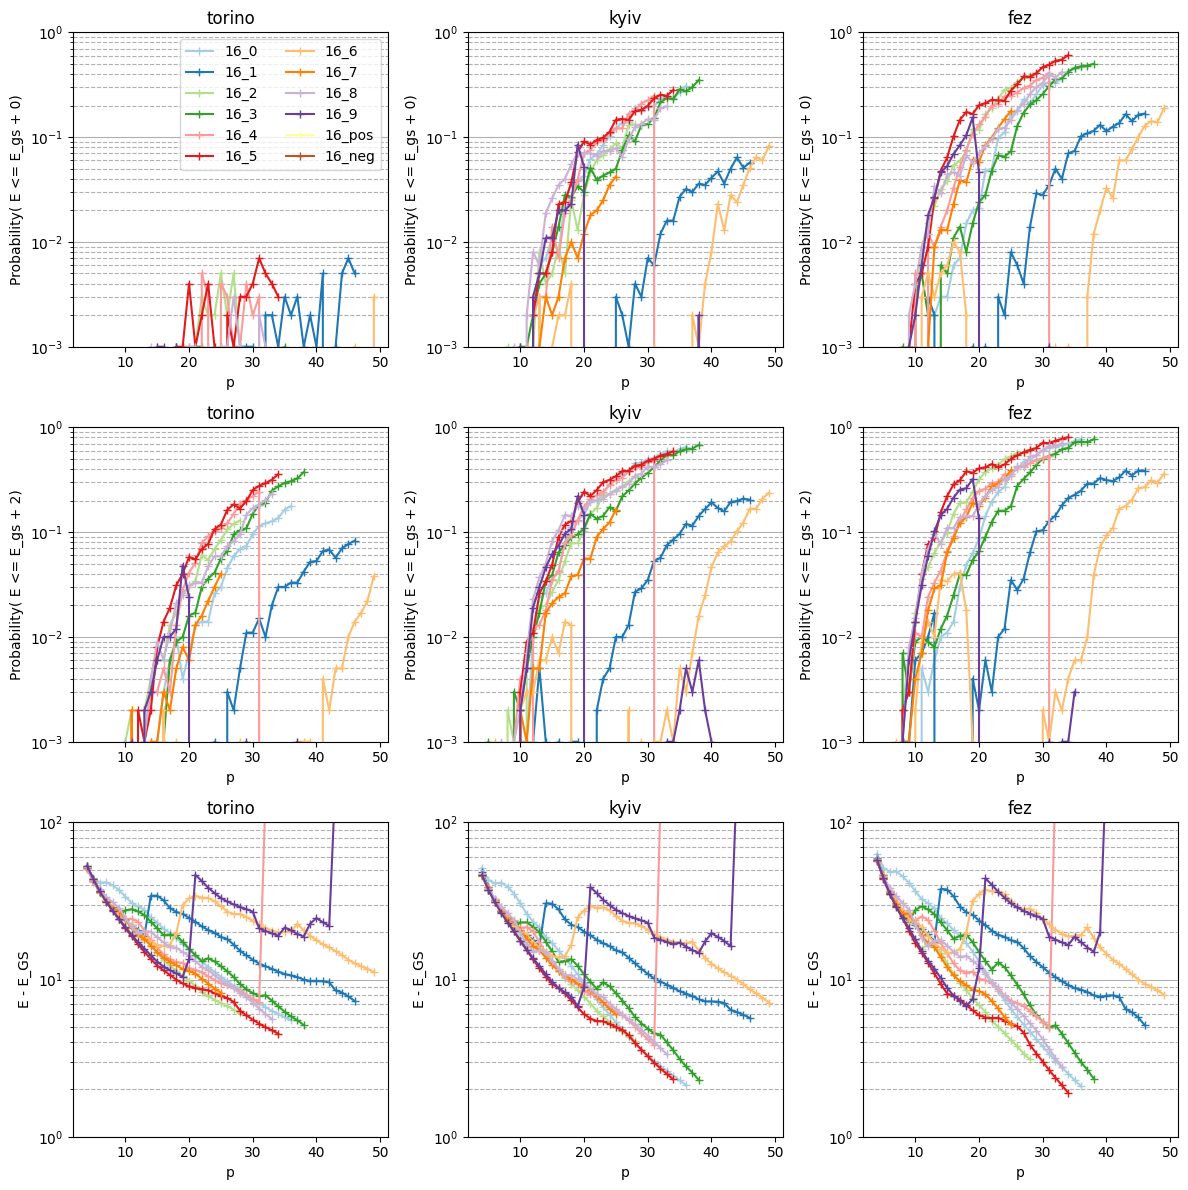

In [17]:
deg = {}
colors = [cm["Paired"](ii) for ii in range(12)]

fig, axs = plt.subplots(3, 3)
fig.set_size_inches(12, 12)

for ii, which in enumerate(['torino', 'kyiv', 'fez']):
    for jj, dE in enumerate([0, 2]):
        for p, c in zip([0,1,2,3,4,5,6,7,8,9,'pos', 'neg'], colors):
            plot_probability_ax(axs[jj, ii], which, 16, p, c, dE=dE)

    for p, c in zip([0,1,2,3,4,5,6,7,8,9,'pos', 'neg'], colors):
        plot_energy_ax(axs[2, ii], which, 16, p, c)


axs[0, 0].legend(ncol=2)
fig.tight_layout()

In [18]:
for k in smpls.keys():
    if k[-1] == 64:
        print(k)

('fez', 16, 0, 1, 64)
('fez', 16, 0, 2, 64)
('fez', 16, 0, 3, 64)
('fez', 16, 0, 4, 64)
('fez', 16, 0, 5, 64)
('fez', 16, 0, 6, 64)
('fez', 16, 0, 7, 64)
('fez', 16, 0, 8, 64)
('fez', 16, 0, 9, 64)
('fez', 16, 0, 10, 64)
('fez', 16, 0, 11, 64)
('fez', 16, 0, 12, 64)
('fez', 16, 0, 13, 64)
('fez', 16, 0, 14, 64)
('fez', 16, 0, 15, 64)
('fez', 16, 0, 16, 64)
('fez', 16, 0, 17, 64)
('fez', 16, 0, 18, 64)
('fez', 16, 0, 19, 64)
('fez', 16, 0, 20, 64)
('fez', 16, 0, 21, 64)
('fez', 16, 0, 22, 64)
('fez', 16, 0, 23, 64)
('fez', 16, 0, 24, 64)
('fez', 16, 0, 25, 64)
('fez', 16, 0, 26, 64)
('fez', 16, 0, 27, 64)
('fez', 16, 0, 28, 64)
('fez', 16, 0, 29, 64)
('fez', 16, 0, 30, 64)
('fez', 16, 0, 31, 64)
('fez', 16, 0, 32, 64)
('fez', 16, 0, 33, 64)
('fez', 16, 0, 34, 64)
('fez', 16, 0, 35, 64)
('fez', 16, 0, 36, 64)
('fez', 16, 1, 1, 64)
('fez', 16, 1, 2, 64)
('fez', 16, 1, 3, 64)
('fez', 16, 1, 4, 64)
('fez', 16, 1, 5, 64)
('fez', 16, 1, 6, 64)
('fez', 16, 1, 7, 64)
('fez', 16, 1, 8, 64)
('fez

In [19]:
dd = {which: {} for which in gs}
aa = {}
for which in gs:
    for ang in [16, 27, 'lin']:
        for les in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'neg.', 'pos.']:
            try:
                ind0 = (which, ang, les) 
                ind = max( [kk for kk in res.keys() if kk[0:3] == ind0])
                dd[which][ang, les] = max(xx["eng"] for xx in res[ind] if xx['env'] == 'BP')
                aa[ang, les] = ind[-1] 
            except ValueError:
                pass

In [20]:
def plot_best(which):
    x, y = [], []
    for k, v in dd[which].items():
        x.append(str(k))
        y.append(v)
    xx = list(range(len(y)))
    y=np.array(y)
    plt.plot(xx, y - gs[which], '-*', label=f"{which}")
    plt.grid(visible=True, axis='y', linestyle='--')
    plt.xticks(xx, x, rotation='vertical');
    # plt.plot([0, len(xx)], [gs[which]] * 2, '--k', label='GS')
    plt.legend()
    plt.ylabel("E(p=max) - E_GS")
    plt.ylim([0, 75])

def plot_max_p():
    x, y = [], []
    for k, v in aa.items():
        x.append(str(k))
        y.append(v)
    xx = list(range(len(y)))
    y=np.array(y)
    plt.plot(xx, y, '--*k', label=f"max p")
    plt.xticks(xx, x, rotation='vertical');
    plt.legend()

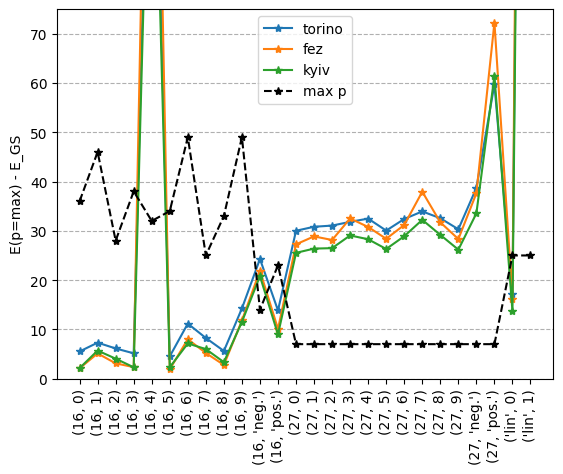

In [21]:
for which in gs:
    plot_best(which)
plot_max_p()

In [22]:
def plot_p(which, p):

    ddd = {}
    for ang in [16, 27, ]:
        for les in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'neg.', 'pos.']:
            try:
                ind = (which, ang, les, p) 
                ddd[ang, les] = max(xx["eng"] for xx in res[ind] if xx['env'] == 'BP')
                #ddd[ang, les] = max(xx["eng"] for xx in res[ind] if xx['env'] == 'CTM')

            except KeyError:
                pass
                
    x, y = [], []
    for k, v in ddd.items():
        x.append(str(k))
        y.append(v)
    xx = list(range(len(y)))
    y = np.array(y)
    plt.plot(xx, y - gs[which], '-*', label=f"{which}")
    plt.grid(visible=True, axis='y', linestyle='--')
    plt.xticks(xx, x, rotation='vertical');
    # plt.plot([0, len(xx)], [gs[which]] * 2, '--k', label='GS')
    plt.legend()
    plt.ylabel("E(p=max) - E_GS")
    plt.title(f"p={p}")



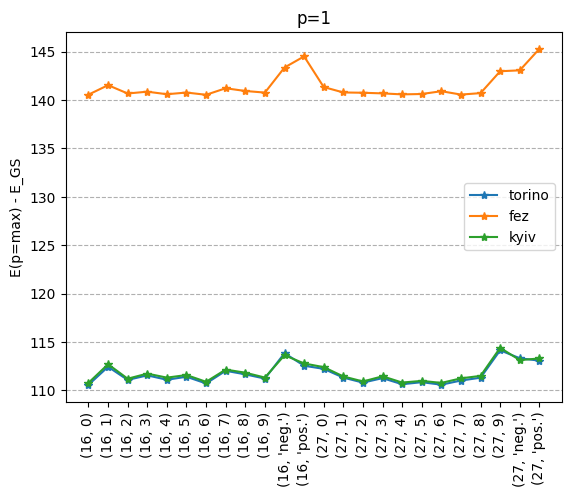

In [23]:
for which in gs:
    plot_p(which, p=1)

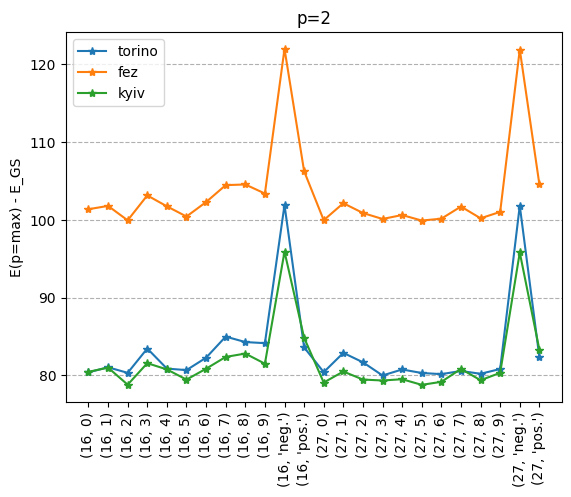

In [24]:
for which in gs:
    plot_p(which, p=2)

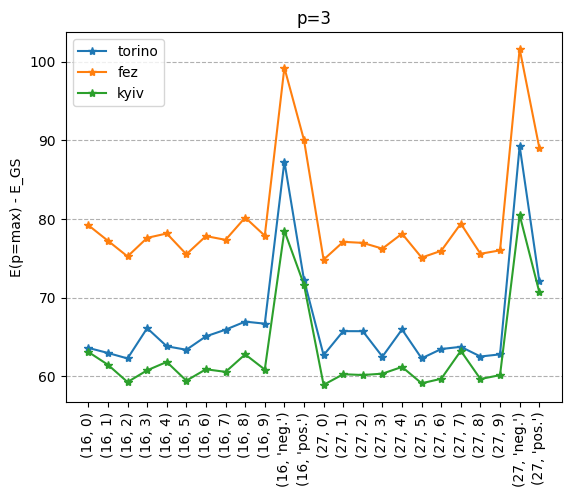

In [25]:
for which in gs:
    plot_p(which, p=3)

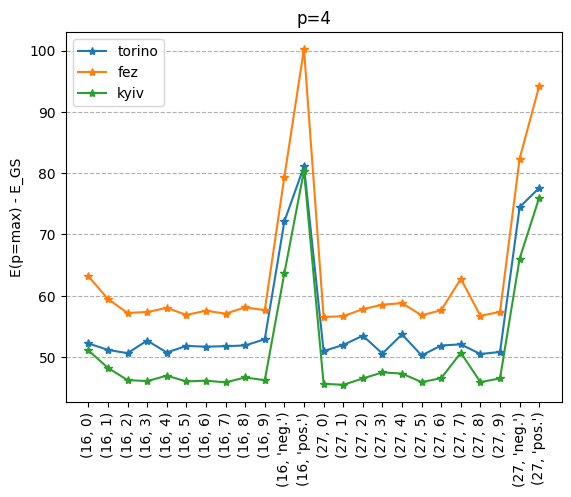

In [26]:
for which in gs:
    plot_p(which, p=4)

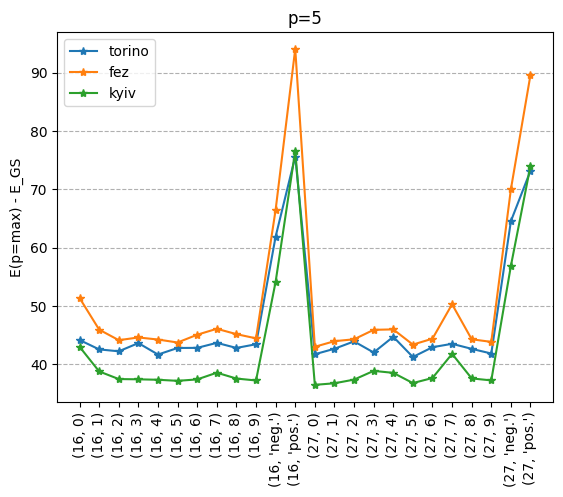

In [27]:
for which in gs:
    plot_p(which, p=5)

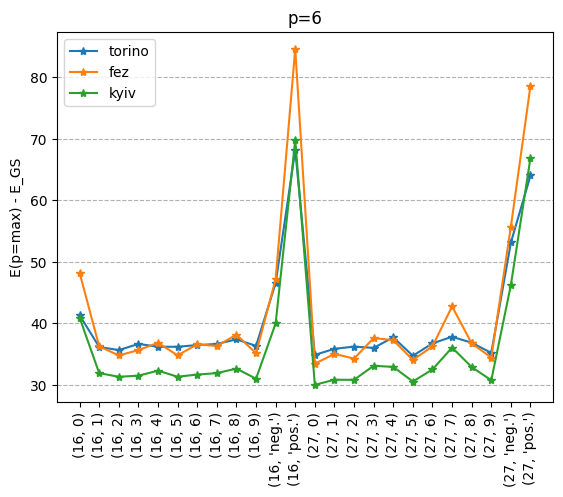

In [28]:
for which in gs:
    plot_p(which, p=6)

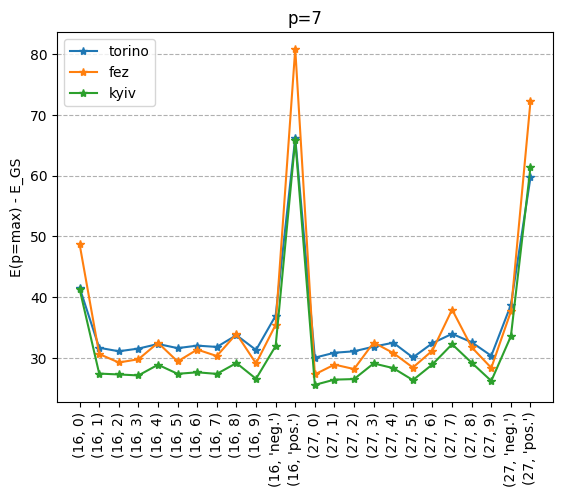

In [29]:
for which in gs:
    plot_p(which, p=7)